# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import imageio

In [2]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from customMetrics import dice_loss, dice_coef, iou

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
from patchify import patchify, unpatchify

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Utils Functions

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    
    top, bottom = [28] * 2
    left, right = [37,38]
    
    x = cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

In [9]:
def read_gt(path):
    x = imageio.mimread(path)[0]  ## (128, 128)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [27]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.tif")))
    y = sorted(glob(os.path.join(path, "1st_manual", "*.gif")))
    return x, y

In [11]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_y, line, y_pred], axis=1)
    
    cv2.imwrite(save_image_path, cat_images)

In [12]:
def save_tests(y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255


    cv2.imwrite(save_image_path, y_pred)

In [13]:
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sen = tp/(tp+fn)
    spe = tn/(tn+fp) 
    return sen, spe

# Setting The Environment

In [14]:
H = 584
W = 565

In [22]:
data_path = "D:\\Data sets\\DRIVE"

In [23]:
""" Save the results in this folder """
create_dir("results")

In [24]:
""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("modelDir/model128.h5")


In [30]:
""" Load the dataset """
traindataset_path = os.path.join(data_path,"training")
train_x, train_y = load_data(traindataset_path)

testdataset_path = os.path.join(data_path,"test")
test_x, test_y = load_data(testdataset_path)

In [29]:
testdataset_path,len(test_x)

('D:\\Data sets\\DRIVE\\test', 20)

In [31]:
traindataset_path,len(train_x)

('D:\\Data sets\\DRIVE\\training', 20)

In [32]:
from matplotlib import pyplot as plt

In [44]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Test.png"
    print(save_image_path)

    save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

01_test
(640, 640, 3) (584, 565)
(584, 565)
results\01_testTest.png


  5%|███████▎                                                                                                                                         | 1/20 [00:02<00:44,  2.36s/it]

02_test
(640, 640, 3) (584, 565)
(584, 565)
results\02_testTest.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:04<00:40,  2.23s/it]

03_test
(640, 640, 3) (584, 565)
(584, 565)
results\03_testTest.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:06<00:37,  2.20s/it]

04_test
(640, 640, 3) (584, 565)
(584, 565)
results\04_testTest.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:08<00:35,  2.21s/it]

05_test
(640, 640, 3) (584, 565)
(584, 565)
results\05_testTest.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:11<00:32,  2.19s/it]

06_test
(640, 640, 3) (584, 565)
(584, 565)
results\06_testTest.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:13<00:31,  2.27s/it]

07_test
(640, 640, 3) (584, 565)
(584, 565)
results\07_testTest.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:15<00:29,  2.26s/it]

08_test
(640, 640, 3) (584, 565)
(584, 565)
results\08_testTest.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:17<00:26,  2.21s/it]

09_test
(640, 640, 3) (584, 565)
(584, 565)
results\09_testTest.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:19<00:23,  2.18s/it]

10_test
(640, 640, 3) (584, 565)
(584, 565)
results\10_testTest.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:22<00:21,  2.16s/it]

11_test
(640, 640, 3) (584, 565)
(584, 565)
results\11_testTest.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:24<00:19,  2.14s/it]

12_test
(640, 640, 3) (584, 565)
(584, 565)
results\12_testTest.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:26<00:16,  2.12s/it]

13_test
(640, 640, 3) (584, 565)
(584, 565)
results\13_testTest.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:28<00:15,  2.16s/it]

14_test
(640, 640, 3) (584, 565)
(584, 565)
results\14_testTest.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:30<00:12,  2.13s/it]

15_test
(640, 640, 3) (584, 565)
(584, 565)
results\15_testTest.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:32<00:10,  2.12s/it]

16_test
(640, 640, 3) (584, 565)
(584, 565)
results\16_testTest.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [00:34<00:08,  2.11s/it]

17_test
(640, 640, 3) (584, 565)
(584, 565)
results\17_testTest.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [00:36<00:06,  2.10s/it]

18_test
(640, 640, 3) (584, 565)
(584, 565)
results\18_testTest.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [00:38<00:04,  2.09s/it]

19_test
(640, 640, 3) (584, 565)
(584, 565)
results\19_testTest.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:40<00:02,  2.09s/it]

20_test
(640, 640, 3) (584, 565)
(584, 565)
results\20_testTest.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.16s/it]


In [34]:
SCORE

[['01_test',
  0.9257182688810764,
  0.3017094017094017,
  0.17765475591343735,
  0.17985733695652173,
  0.9355123674911661,
  0.17985733695652173,
  0.9987854385731398],
 ['02_test',
  0.9097860346708692,
  0.22544300174338425,
  0.127041848734567,
  0.12820361053566143,
  0.9334195216548158,
  0.12820361053566143,
  0.9989566802849714],
 ['03_test',
  0.9240544308401019,
  0.39641592600621434,
  0.2472062004325883,
  0.25017480922992735,
  0.9541975881261595,
  0.25017480922992735,
  0.9986703336284407],
 ['04_test',
  0.928103406473512,
  0.36932074970091716,
  0.2264827676155075,
  0.2288331027212229,
  0.9566175457925905,
  0.2288331027212229,
  0.9989486191865317],
 ['05_test',
  0.9214571463207661,
  0.28731712682873173,
  0.16775850995504174,
  0.16899585921325053,
  0.9581804842259721,
  0.16899585921325053,
  0.9992375805890693],
 ['06_test',
  0.9149351436537763,
  0.23240168462506153,
  0.1314787882538602,
  0.1323016564952049,
  0.9548314606741573,
  0.1323016564952049,
  

In [35]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")



Accuracy: 0.92392
F1: 0.23779
Jaccard: 0.14090
Recall: 0.14272
Precision: 0.90999
Sensitivity: 0.14272
Specificity: 0.99895


In [36]:
""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,01_test,0.925718,0.301709,0.177655,0.179857,0.935512,0.179857,0.998785
1,02_test,0.909786,0.225443,0.127042,0.128204,0.933420,0.128204,0.998957
2,03_test,0.924054,0.396416,0.247206,0.250175,0.954198,0.250175,0.998670
3,04_test,0.928103,0.369321,0.226483,0.228833,0.956618,0.228833,0.998949
4,05_test,0.921457,0.287317,0.167759,0.168996,0.958180,0.168996,0.999238
5,06_test,0.914935,0.232402,0.131479,0.132302,0.954831,0.132302,0.999325
6,07_test,0.917814,0.196742,0.109103,0.110142,0.920455,0.110142,0.999043
7,08_test,0.920618,0.157971,0.085759,0.086548,0.903974,0.086548,0.999135
8,09_test,0.920915,0.064394,0.033268,0.033581,0.780870,0.033581,0.999169
9,10_test,0.932177,0.305194,0.180076,0.180991,0.972689,0.180991,0.999544


In [37]:
# df.to_csv("files/score.csv")


In [38]:
import seaborn as sns

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

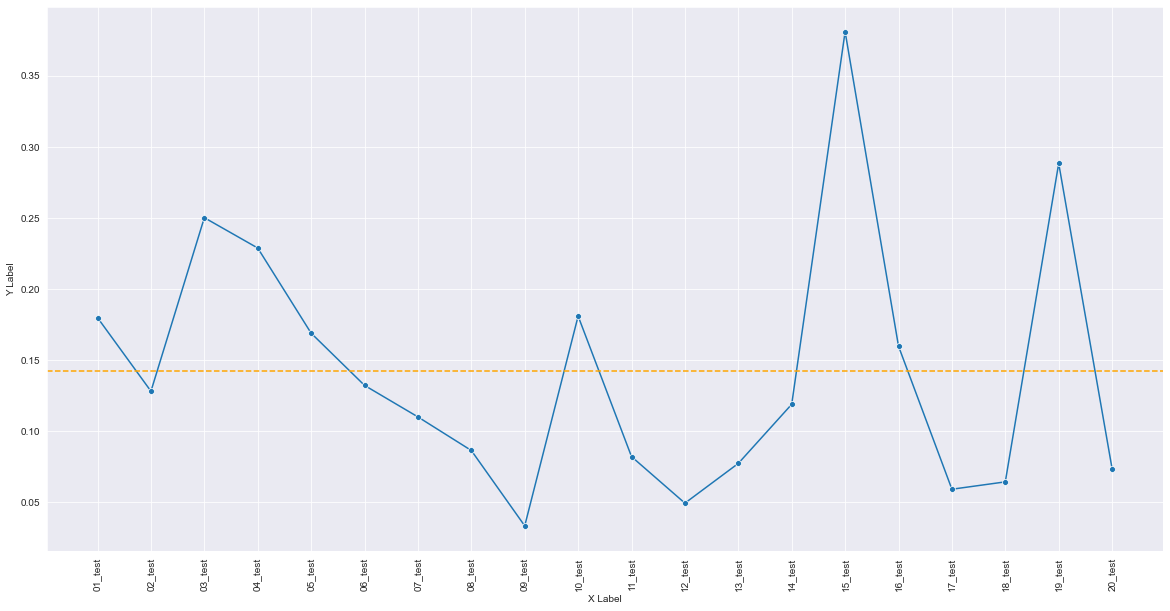

In [43]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=df, x="Image", y="Sensitivity", marker = "o")
ax.axhline(df["Sensitivity"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "Y Label")
plt.setp(ax.get_xticklabels(), rotation=90)
